# Compare cost of gasification and CHP systems of same power rating

In [2]:
import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import settings
from functions.general.utility import get_project_root
from functions.TEA import convert_currency_annual_average
from functions.TEA.scaling import CEPCI_scale
from functions.general.curve_fitting import display_curve_fits
from functions.general import convert_system_size
from functions.general.curve_fitting import func_power_curve, func_straight_line


### Load data and do some data wrangling

In [3]:
# General parameters
root_dir = get_project_root()
updated_currency = "GBP"
updated_CEPCI_year = 2020
plot_style = settings.plotting.digital

In [4]:
# Load and display data
data_file_gas = "CAPEX_Gasification.csv"
data_file_path_gas = os.path.join(root_dir, "data", data_file_gas)
df_source_gas = pd.read_csv(data_file_path_gas)
df_gas = df_source_gas.copy()  # working copy of original dataframe

# Convert all values to same currency and update to most recent CEPCI value
CAPEX_currency_scaled_gas = []
CAPEX_currency_CEPCI_scaled_gas = []

for row_no in df_gas.index:
    CAPEX_currency_scaled_gas.append(
        convert_currency_annual_average(value=df_gas["CAPEX"][row_no], year=df_gas["Reference Year"][row_no],
                                        base_currency=df_gas["Currency"][row_no], converted_currency=updated_currency))
    CAPEX_currency_CEPCI_scaled_gas.append(
        CEPCI_scale(base_year=df_gas["Reference Year"][row_no], design_year=updated_CEPCI_year,
                    value=CAPEX_currency_scaled_gas[row_no]))

# Add (i) currency and (ii) currency + CEPCI scaled values to dataframe
currency_scaled_label_gas = "CAPEX_" + updated_currency
currency_and_CEPCI_scaled_label_gas = "CAPEX_" + updated_currency + "_CEPCI_" + str(updated_CEPCI_year)

df_gas[currency_scaled_label_gas] = CAPEX_currency_scaled_gas
df_gas[currency_and_CEPCI_scaled_label_gas] = CAPEX_currency_CEPCI_scaled_gas

# Also add to original dataframe
df_source_gas[currency_scaled_label_gas] = CAPEX_currency_scaled_gas
df_source_gas[currency_and_CEPCI_scaled_label_gas] = CAPEX_currency_CEPCI_scaled_gas

df_gas

,Process Reference,Gas Cleaning Included,Power Generation Included,Type,CAPEX,Currency,Plant size [tonnes/hour],Plant size [MW feedstock LHV] or [MWh/hour],Plant size [MWth],Plant size [MWel],Reference Year,Country,Scaling factor,Balance of plant costs/Overall installation factor,Comments,Reference,CAPEX_GBP,CAPEX_GBP_CEPCI_2020
0,Gasification unit + gas cleaning,True,False,fixed bed,1721500,EUR,NaN,5.0,NaN,1.100,2014,Poland,NaN,NaN,calculated 3 instances from equations given in...,https://doi.org/10.1016/j.energy.2014.01.015,1.387782e+06,1.439333e+06
1,Gasification unit + gas cleaning,True,False,fixed bed,5324000,EUR,NaN,20.0,NaN,4.400,2014,Poland,NaN,NaN,calculated 3 instances from equations given in...,https://doi.org/10.1016/j.energy.2014.01.015,4.291926e+06,4.451355e+06
2,Gasification unit + gas cleaning,True,False,fixed bed,8316000,EUR,NaN,35.0,NaN,7.700,2014,Poland,NaN,NaN,calculated 3 instances from equations given in...,https://doi.org/10.1016/j.energy.2014.01.015,6.703917e+06,6.952943e+06
3,Bubbling fluidised bed gasifier,False,False,fluidised bed,660000,EUR,0.740000,NaN,0.4,0.400,2015,Italy,NaN,NaN,calculated plant size in tonnes/hour from 5320...,http://dx.doi.org/10.1016/j.fuproc.2014.11.003,4.793188e+05,5.143552e+05
4,Bubbling fluidised bed air gasifier + power pr...,True,True,fluidised bed,2430000,EUR,0.500000,NaN,NaN,0.500,2012,Italy,NaN,NaN,plant input also quoted as 3840 tonnes/year,http://dx.doi.org/10.1016/j.energy.2012.03.048,1.971294e+06,2.014794e+06
5,Biomass gasifier with rankine cycle + all aces...,True,True,fluidised bed,2073183,EUR,0.910000,NaN,NaN,NaN,2019,Mexico,NaN,NaN,"total costs, including installation, planning,...",http://dx.doi.org/10.1016/j.energy.2019.116095,1.818665e+06,1.754930e+06
6,Gasifier equipment cost only,False,False,fluidised bed,72380,USD,0.100000,NaN,NaN,0.419,2020,USA,NaN,NaN,This represents only 2.5% of the BIGCC plant's...,https://doi.org/10.1016/j.compchemeng.2020.106758,5.642775e+04,5.642775e+04
7,Indirect gasifier,False,False,fluidised bed,8000000,EUR,NaN,8.0,NaN,NaN,2003,Europe,0.72,3.800,Base equipment cost would be quoted CAPEX scal...,https://doi.org/10.1002/er.3038,5.536412e+06,8.228871e+06
8,Indirect gasifier with gas cleaning (17% of to...,True,False,fluidised bed,52816426,EUR,NaN,100.0,NaN,NaN,2003,Europe,NaN,NaN,83% of this is the cost for the gasifier; 17% ...,https://doi.org/10.1002/er.3038,3.655169e+07,5.432745e+07
9,Entrained flow steam Gasification,False,False,entrained flow,14933333,USD,20.833333,NaN,NaN,NaN,2007,USA,0.60,2.310,CAPEX for cleaning equipment has been removed;...,Process Design and Economics for Conversion of...,7.459688e+06,8.483371e+06


In [5]:
# Fill in missing data for gasification dataset
# Fill in plant size [tonnes/hour] data
for count, value in enumerate(df_source_gas["Plant size [tonnes/hour]"]):
    if math.isnan(value):
        plant_size_kWh_per_hour_feedstock = df_gas.loc[count, "Plant size [MW feedstock LHV] or [MWh/hour]"] * 1000
        plant_size_MWel = df_gas.loc[count, "Plant size [MWel]"]

        if not math.isnan(plant_size_kWh_per_hour_feedstock):  # replace based on plant_size_MW_feedstock first
            converted_value = convert_system_size(value=plant_size_kWh_per_hour_feedstock,
                                                  input_units="kWh/hour",
                                                  output_units="tonnes/hour")
        else:
            if not math.isnan(plant_size_MWel):  # otherwise replace based on plant_size_MWel
                converted_value = convert_system_size(value=plant_size_MWel,
                                                      input_units="MWel",
                                                      output_units="tonnes/hour")
            else:  # no suitable reference value to convert from - leave as nan
                converted_value = np.NAN
        # populate data frame
        df_gas.loc[count, ["Plant size [tonnes/hour]"]] = converted_value

# Fill in plant size [MWel] data
for count, value in enumerate(df_source_gas["Plant size [MWel]"]):
    if math.isnan(value):
        plant_size_kWh_per_hour_feedstock = df_gas.loc[count, "Plant size [MW feedstock LHV] or [MWh/hour]"] * 1000
        plant_size_tonnes_per_hour = df_gas.loc[count, "Plant size [tonnes/hour]"]

        if not math.isnan(plant_size_kWh_per_hour_feedstock):  # replace based on plant_size_MW_feedstock first
            converted_value = convert_system_size(value=plant_size_kWh_per_hour_feedstock,
                                                  input_units="kWh/hour",
                                                  output_units="MWel")
        else:
            if not math.isnan(plant_size_tonnes_per_hour):  # otherwise replace based on plant_size_tonnes_per_hour
                converted_value = convert_system_size(value=plant_size_tonnes_per_hour,
                                                      input_units="tonnes/hour",
                                                      output_units="MWel")
            else:  # no suitable reference value to convert from - leave as nan
                converted_value = np.NAN
        # populate data frame
        df_gas.loc[count, ["Plant size [MWel]"]] = converted_value

# Fill in plant size [MW feedstock LHV] or [MWh/hour] data
for count, value in enumerate(df_source_gas["Plant size [MW feedstock LHV] or [MWh/hour]"]):
    if math.isnan(value):
        plant_size_MWel = df_gas.loc[count, "Plant size [MWel]"]
        plant_size_tonnes_per_hour = df_gas.loc[count, "Plant size [tonnes/hour]"]


        if not math.isnan(plant_size_MWel):  # replace based on plant_size_MWel
            converted_value = convert_system_size(value=plant_size_MWel,
                                                      input_units="MWel",
                                                      output_units="kWh/hour") / 1000
        else:
            if not math.isnan(plant_size_tonnes_per_hour):  # otherwise replace based on plant_size_tonnes_per_hour
                converted_value = convert_system_size(value=plant_size_tonnes_per_hour,
                                                      input_units="tonnes/hour",
                                                      output_units="kWh/hour") / 1000
            else:  # no suitable reference value to convert from - leave as nan
                converted_value = np.NAN
        # populate data frame
        df_gas.loc[count, ["Plant size [MW feedstock LHV] or [MWh/hour]"]] = converted_value


C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\functions\general\system_size_conversion.py:88: UserWarning: Input significantly outside range of training data.
  warn("Input significantly outside range of training data.")
C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\functions\general\system_size_conversion.py:88: UserWarning: Input significantly outside range of training data.
  warn("Input significantly outside range of training data.")
C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\functions\general\system_size_conversion.py:88: UserWarning: Input significantly outside range of training data.
  warn("Input significantly outside range of training data.")
C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\functions\general\system_size_conversion.py:88: UserWarning: Input significantly outside range of training data.
  warn("Input significantly outside range of training data.")
C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\functions\general\system_size_conversion.py:86: UserWarning: Input sig

In [6]:
# Add new column for plotting which indicates whether gas cleaning and power generation are included in cost data
cleaning_and_power_generation = []
for row_no in df_gas.index:
    gas_cleaning_cond = False
    power_gen_cond = False
    if df_gas["Gas Cleaning Included"][row_no] and df_gas["Power Generation Included"][row_no]:
        label = "Gas Cleaning + Power Generation"
    elif df_gas["Gas Cleaning Included"][row_no] and not df_gas["Power Generation Included"][row_no]:
        label = "Gas Cleaning"
    elif not df_gas["Gas Cleaning Included"][row_no] and df_gas["Power Generation Included"][row_no]:
        label = "Power Generation"
    else:
        label = "Gasification only"

    cleaning_and_power_generation.append(label)

# Add cleaning and power generation descriptors to df
df_gas["Cleaning and Power Generation"] = cleaning_and_power_generation

In [7]:
# Manually remove one extreme outlier in the data
df_gas = df_gas[df_gas["Reference"] != "https://doi.org/10.1016/j.compchemeng.2020.106758"].copy()

In [8]:
# Add additional cost column which excludes cleaning cost if cleaning was included in cost
df_gas["CAPEX_scaled_without_cleaning"] = np.array(np.where(df_gas["Cleaning and Power Generation"] != "Gasification only",
                                                            df_gas[currency_and_CEPCI_scaled_label_gas] * 0.76,
                                                            df_gas[currency_and_CEPCI_scaled_label_gas]))

In [9]:
# Load CHP data
data_file_CHP = "CAPEX_CHP.csv"
data_file_path_CHP = os.path.join(root_dir, "data", data_file_CHP)
df_CHP = pd.read_csv(data_file_path_CHP)

# Convert all values to same currency and update to most recent CEPCI value
CAPEX_currency_scaled_CHP = []
CAPEX_currency_CEPCI_scaled_CHP = []

for row_no in df_CHP.index:
    CAPEX_currency_scaled_CHP.append(
        convert_currency_annual_average(value=df_CHP["CAPEX"][row_no], year=df_CHP["Reference Year"][row_no],
                                        base_currency=df_CHP["Currency"][row_no], converted_currency=updated_currency))
    CAPEX_currency_CEPCI_scaled_CHP.append(
        CEPCI_scale(base_year=df_CHP["Reference Year"][row_no], design_year=updated_CEPCI_year,
                    value=CAPEX_currency_scaled_CHP[row_no]))

# Add (i) currency and (ii) currency + CEPCI scaled values to dataframe
currency_scaled_label_CHP = "CAPEX_" + updated_currency
currency_and_CEPCI_scaled_label_CHP = "CAPEX_" + updated_currency + "_CEPCI_" + str(updated_CEPCI_year)

df_CHP[currency_scaled_label_CHP] = CAPEX_currency_scaled_CHP
df_CHP[currency_and_CEPCI_scaled_label_CHP] = CAPEX_currency_CEPCI_scaled_CHP

# Add system size in MWel to df
df_CHP["Plant size [MWel]"]= df_CHP["Plant size [kWel]"]/1000

df_CHP

,Process Reference,Type,CAPEX,Currency,Plant size [kWel],Reference Year,Country,Scaling factor,Balance of plant costs/Overall installation factor,Comments,Reference,CAPEX_GBP,CAPEX_GBP_CEPCI_2020,Plant size [MWel]
0,Steam turbine for biomass oxycombustion with CCS,steam turbine,5.942000e+08,GBP,598000.00,2018,UK,NaN,NaN,Case 9; reference year estimated based on year...,https://assets.publishing.service.gov.uk/gover...,5.942000e+08,5.886826e+08,598.00000
1,Steam turbine for coal oxycombustion with CCS,steam turbine,7.745000e+08,GBP,1097700.00,2018,UK,NaN,NaN,Case 9; reference year estimated based on year...,https://assets.publishing.service.gov.uk/gover...,7.745000e+08,7.673085e+08,1097.70000
2,Stirling Engine,stirling engine,1.020600e+06,GBP,255.15,2017,UK,NaN,NaN,CAPEX range: 3000-7200 (year 2030 vs 2012),https://doi.org/10.1016/j.energy.2017.11.106,1.020600e+06,1.074552e+06,0.25515
3,Piston Engine (Skorek-Osikowska et al. Case 1),piston engine,5.798732e+05,EUR,322.21,2014,Poland,NaN,NaN,cost estimated from equation 25; power of indi...,10.1016/j.energy.2014.01.015,4.674629e+05,4.848275e+05,0.32221
4,Piston Engine (Skorek-Osikowska et al. Case 2),piston engine,2.078835e+06,EUR,1154.02,2014,Poland,NaN,NaN,cost estimated from equation 25; power of indi...,10.1016/j.energy.2014.01.015,1.675846e+06,1.738098e+06,1.15402
5,Piston Engine (Skorek-Osikowska et al. Example 1),piston engine,1.795602e+05,EUR,100.00,2014,Poland,NaN,NaN,cost estimated from equation 25; power of indi...,10.1016/j.energy.2014.01.015,1.447519e+05,1.501289e+05,0.10000
6,Piston Engine (Skorek-Osikowska et al. Example 2),piston engine,9.010117e+06,EUR,5000.00,2014,Poland,NaN,NaN,cost estimated from equation 25; power of indi...,10.1016/j.energy.2014.01.015,7.263477e+06,7.533289e+06,5.00000
7,Piston Engine based electricity generation system,piston engine,4.228242e+06,EUR,1400.08,2014,Poland,NaN,NaN,calculated from equations given in reference f...,10.1016/j.energy.2014.01.015 AND https://doi.o...,3.408584e+06,3.535200e+06,1.40008
8,Steam Turbine and Steam system,steam turbine,4.584500e+07,USD,64411.00,2007,USA,NaN,NaN,"also includes steam generation system, TIC (t...",Process Design and Economics for Conversion of...,2.290108e+07,2.604376e+07,64.41100
9,Combustion turbine + accessories (Shell IGCC ...,gas turbine,8.444800e+07,USD,464000.00,2019,USA,NaN,NaN,lower case,COST AND PERFORMANCE BASELINE FOR FOSSIL ENERG...,6.617171e+07,6.385270e+07,464.00000


### Show complete data sets for gasification and CHP

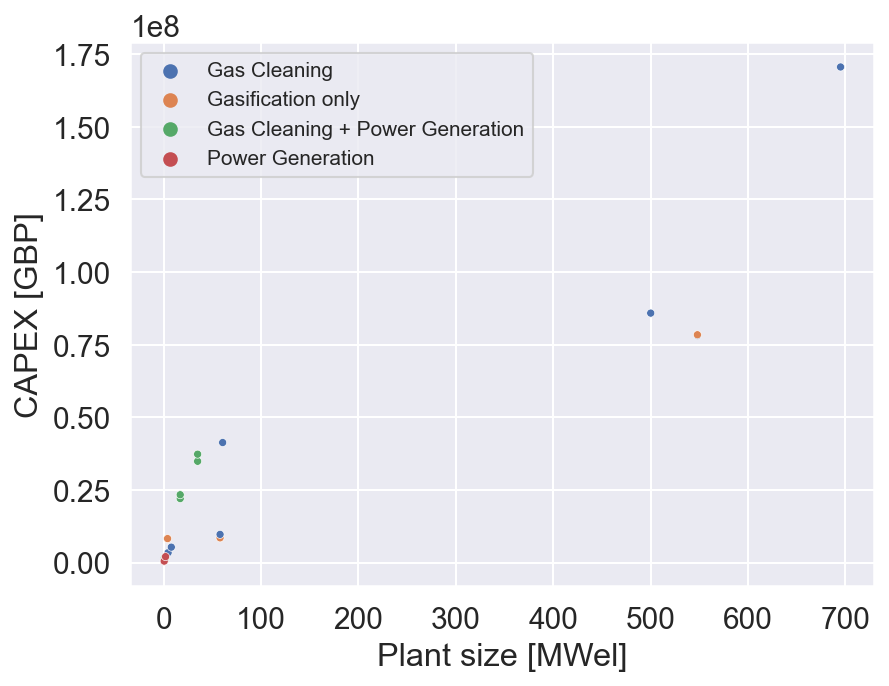

In [10]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_gas, x="Plant size [MWel]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=10)
plt.show()

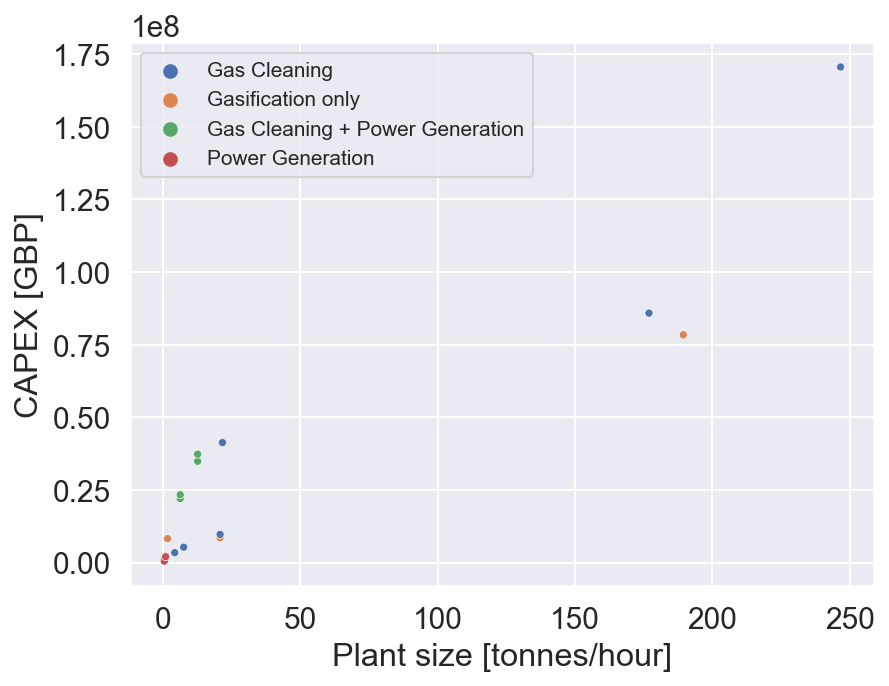

In [11]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_gas, x="Plant size [tonnes/hour]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=10)
plt.show()

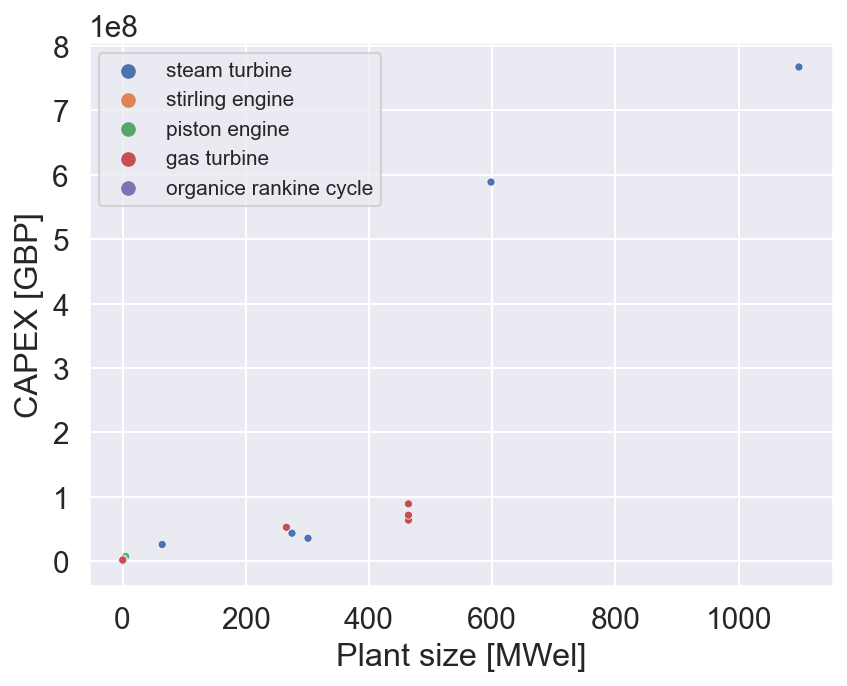

In [12]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_CHP, x="Plant size [MWel]", y=currency_and_CEPCI_scaled_label_CHP, hue="Type", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=10)
plt.show()


Summary:
- Gasification:
    - Data has a main cluster of plants sized < 100 MWel.
    - Discard larger data points for rest of analysis.
    - Too sparse from there and too little data.

- CHP
    - One cluster of plants sized 0-5 MWel with many concentrated in the kW range (0-1000kW).
    - Rest of data is clustered between 50-500 MWel.
    - Some much more expensive steam turbine data for plants > 500 MWel.
        - Too distance from rest of data and too sparse to effectively incorporate into model.
        - Discard these data points.

In [13]:
# Introduce limits to main data frame - i.e. discard very large data/region where data gets too sparse
df_gas = df_gas[df_gas["Plant size [MWel]"]<100]
df_CHP = df_CHP[df_CHP["Plant size [MWel]"]<500]

### Display data after discarding outliers/regions of too greate sparsity

#### Gasification

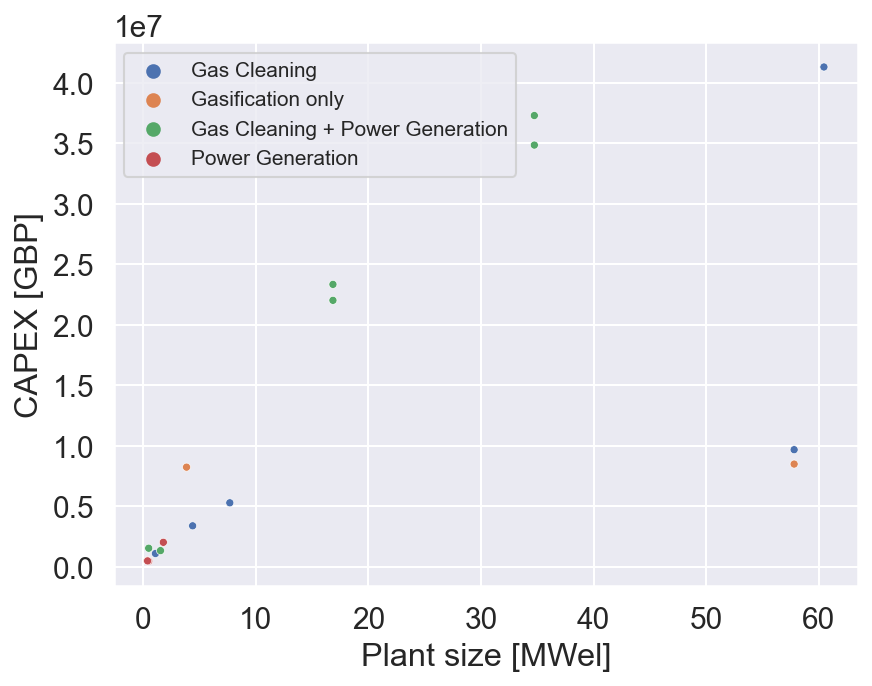

In [14]:
# Show whether gas cleaning and power generation are included in cost data
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_gas, x="Plant size [MWel]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=10)
plt.show()

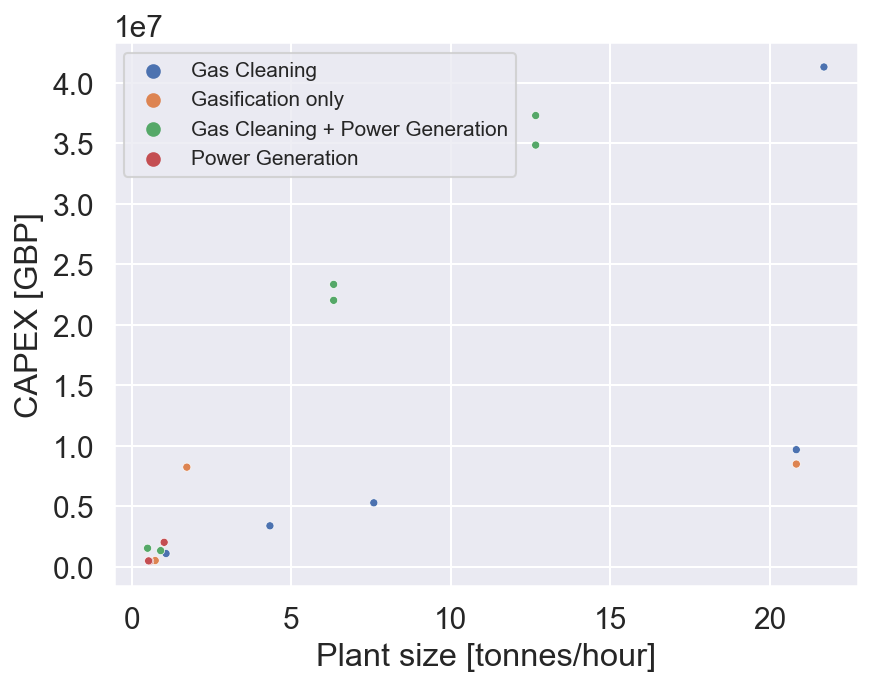

In [38]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_gas, x="Plant size [tonnes/hour]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=10)
plt.show()

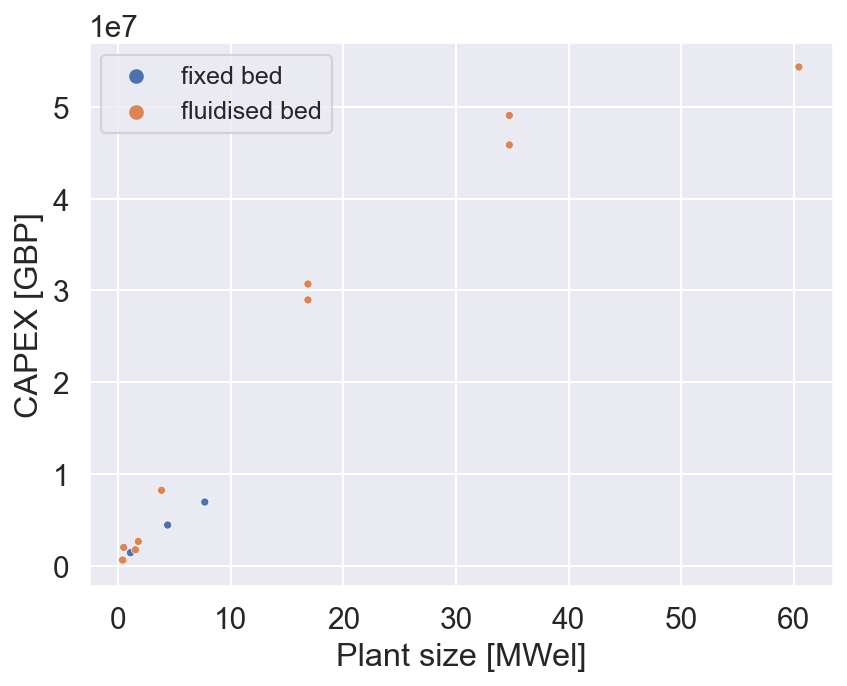

In [42]:
# Show reactor type
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_gas[df_gas["Type"] != "entrained flow"], x="Plant size [MWel]", y=currency_and_CEPCI_scaled_label_CHP, hue="Type", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=12)
plt.show()



In [16]:
# Check if all of fixed bed gasifier data is from same reference
df_gas[df_gas["Type"]== "fixed bed"]["Reference"]

0    https://doi.org/10.1016/j.energy.2014.01.015 
1    https://doi.org/10.1016/j.energy.2014.01.015 
2    https://doi.org/10.1016/j.energy.2014.01.015 
Name: Reference, dtype: object

In [17]:
# Check if all of entrained flow gasifier data is from same reference
df_gas[df_gas["Type"]== "entrained flow"]["Reference"]

9     Process Design and Economics for Conversion of...
10    Process Design and Economics for Conversion of...
Name: Reference, dtype: object

- Clear trend visible for fluidised bed gasification.
- Fixed bed gasification data shows a fairly linear relationship - this is all based on one reference.
- Entrained flow data not usable - only 2 data points (one including gas cleaning and the other is not).

#### Fluidised bed gasifier model

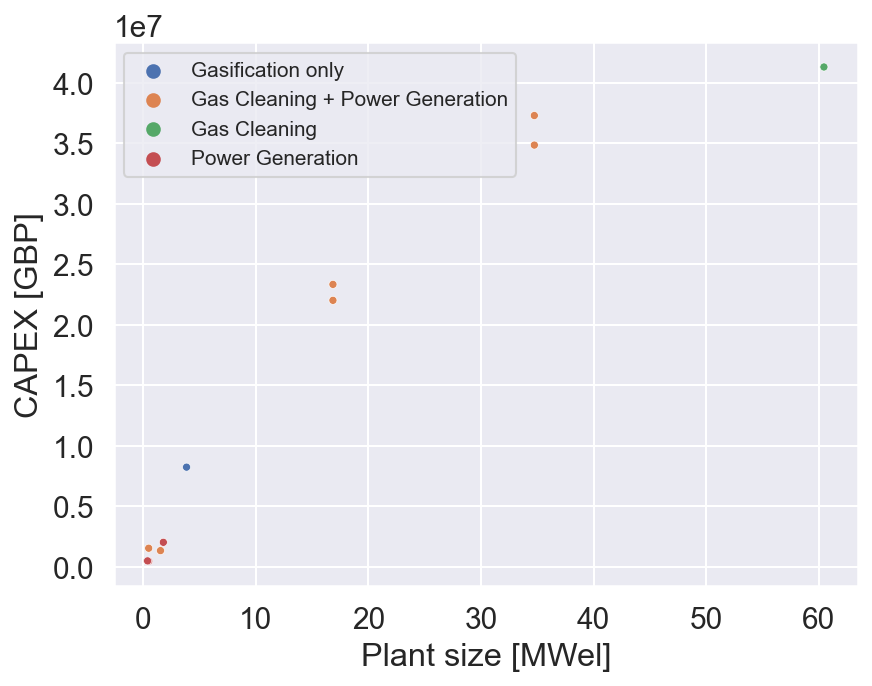

In [40]:
# Show data for fluidised bed reactors only
df_gas_fluidised = df_gas[df_gas["Type"] == "fluidised bed"]

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_gas_fluidised, x="Plant size [MWel]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=10)
plt.show()


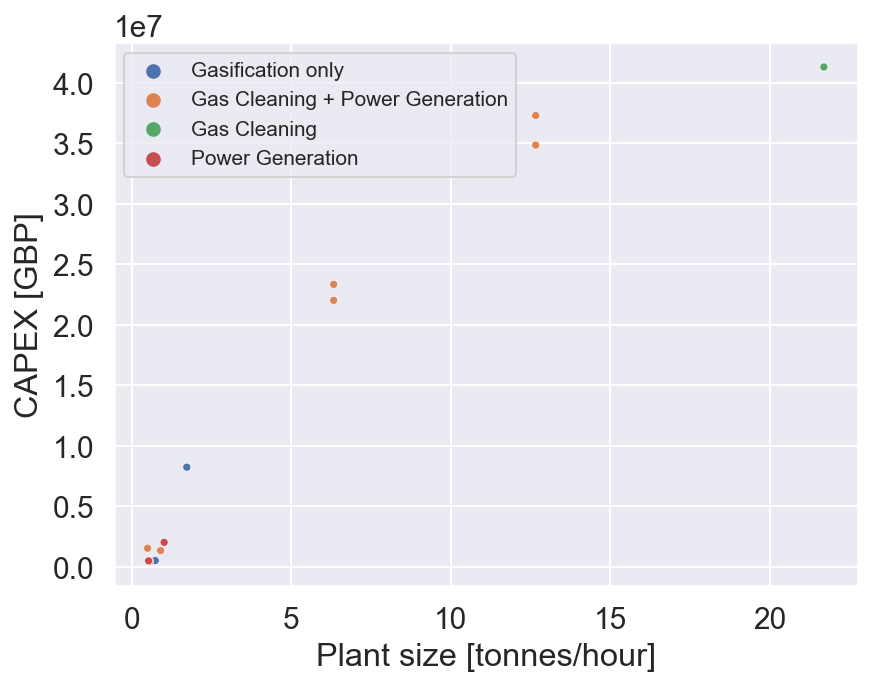

In [39]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_gas_fluidised, x="Plant size [tonnes/hour]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=10)
plt.show()

Clear trend visible.
Curve fit shown below:

Straight line fit: R2: 0.902; RMSE: 4863746; MAPE: 198 %
Power curve fit: R2: 0.984; RMSE: 1956506; MAPE: 82 %
2nd degree polynomial fit: R2: 0.995; RMSE: 1045506; MAPE: 35 %
3rd degree polynomial: R2: 0.996; RMSE: 952157; MAPE: 25 %


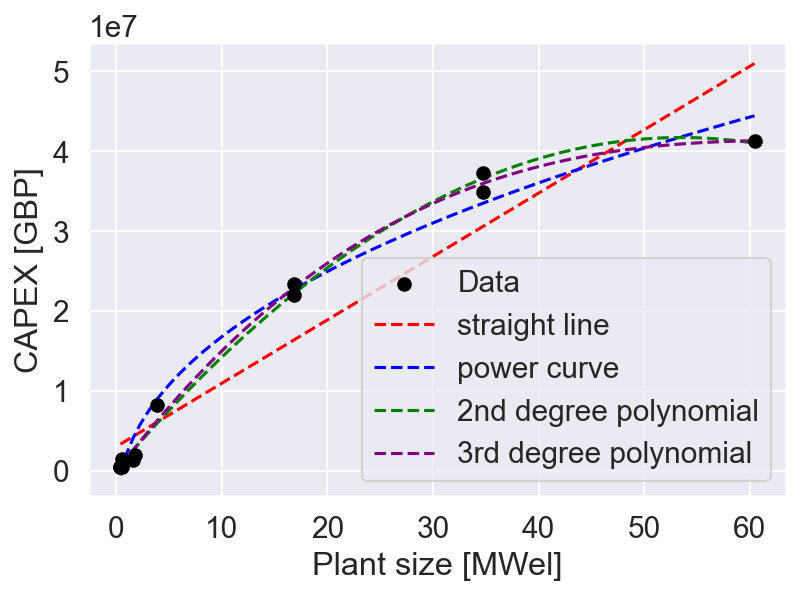

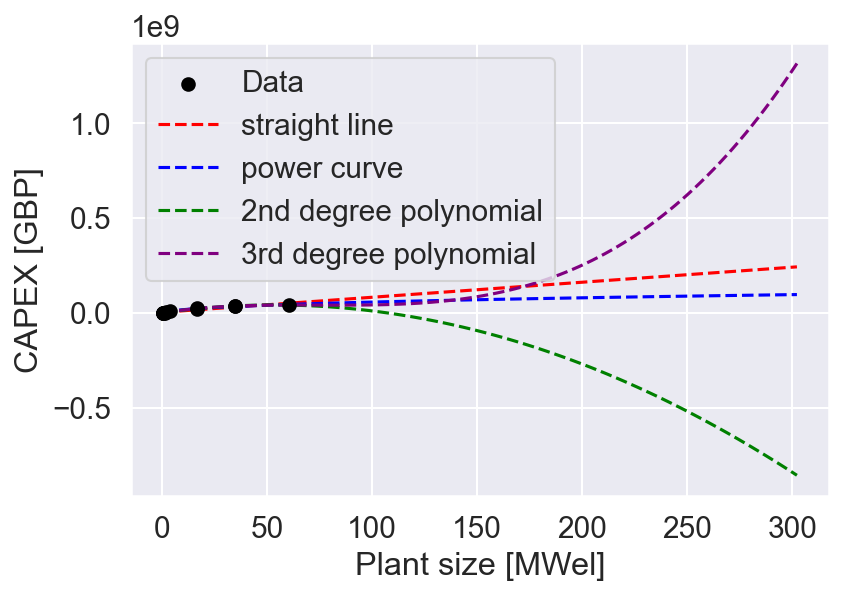

{'straight_line': {'Constants': array([ 793379.42394471, 3030154.70772398]),
  'R2': 0.9024517372929363,
  'RMSE': 4863745.975967556},
 'power_curve': {'Constants': array([ 8.30633259e+06,  4.40248395e-01, -6.10467938e+06]),
  'R2': 0.9842151668634405,
  'RMSE': 1956505.6776528002},
 '2nd_degree_polynomial': {'Constants': array([1554209.04296924,  -14527.52188724,  142651.82889741]),
  'R2': 0.9954925531126054,
  'RMSE': 1045505.7457517065},
 '3rd_degree_polynomial': {'Constants': array([ 1.74506407e+06, -2.40631621e+04,  1.08202855e+02, -1.47716102e+05]),
  'R2': 0.996261517836687,
  'RMSE': 952157.4533614932},
 'data_range': {'min': 0.4, 'max': 60.44089063568641}}

In [19]:
# Show curve fit
display_curve_fits(dataframe=df_gas_fluidised, x_data_label="Plant size [MWel]", y_data_label="CAPEX_scaled_without_cleaning", plot_y_label="CAPEX [GBP]")


- Curves generally show trend well - potentially not enough resolution in <5 MWel region.
- Difficult to identify any clear trends on increased CAPEX when gas cleaning and power generation are included in quoted value.

Zoom in to show gasification data at similar scale to CHP (i.e. < 5MWel)


#### Small-scale plants of a size <5 MWel

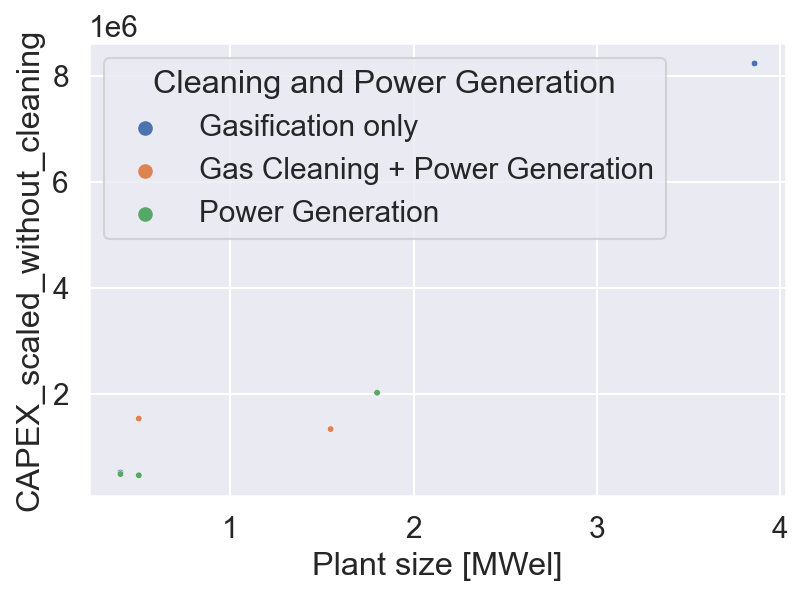

In [20]:
# Show data for reactors of same size
fig, ax = plt.subplots(dpi=150)
sns.scatterplot(data=df_gas_fluidised[df_gas_fluidised["Plant size [MWel]"]<5], x="Plant size [MWel]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=10)
plt.show()


Trend less clear in this region but should still be able to fit a decent curve.
Curve fit shown below:

Straight line fit: R2: 0.647; RMSE: 1384931; MAPE: 36 %
Power curve fit: R2: 0.647; RMSE: 1384884; MAPE: 36 %
2nd degree polynomial fit: R2: 0.651; RMSE: 1376870; MAPE: 41 %
3rd degree polynomial: R2: 0.941; RMSE: 567084; MAPE: 48 %


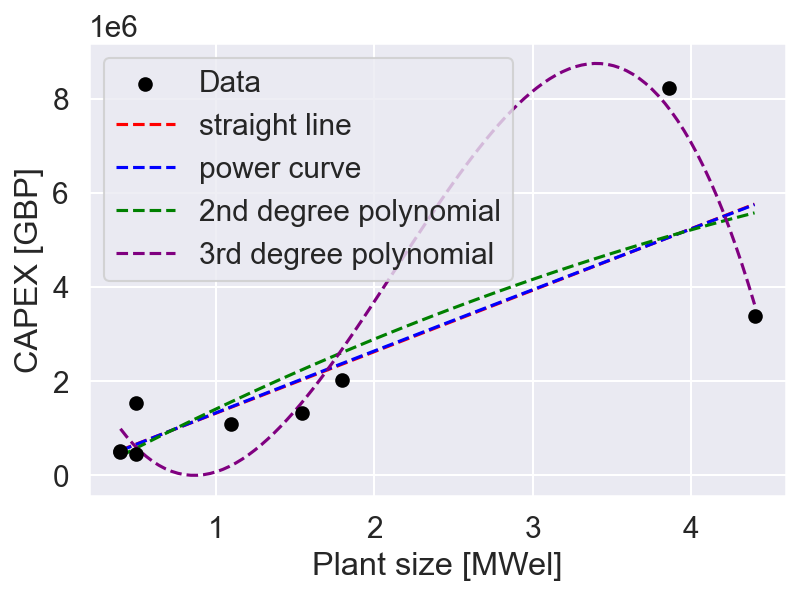

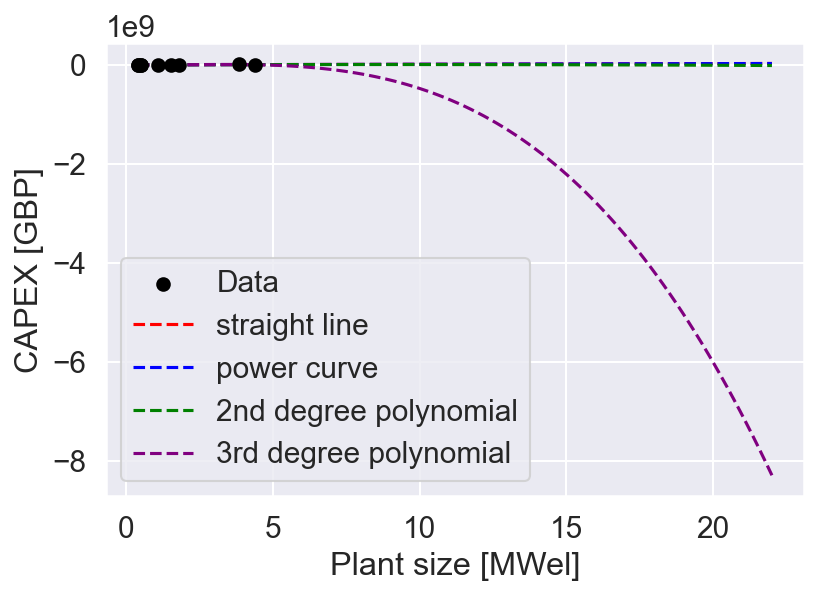

{'straight_line': {'Constants': array([1307335.12547653,    9876.32017483]),
  'R2': 0.6472715493674096,
  'RMSE': 1384931.2367383463},
 'power_curve': {'Constants': array([ 1.35030619e+06,  9.81134810e-01, -2.55140899e+04]),
  'R2': 0.6472954924943624,
  'RMSE': 1384884.231532078},
 '2nd_degree_polynomial': {'Constants': array([1812139.31843698, -108370.33428923, -299048.96624671]),
  'R2': 0.6513656381339419,
  'RMSE': 1376870.3892475802},
 '3rd_degree_polynomial': {'Constants': array([-9459050.6265626 ,  6857400.84745988, -1071237.13143079,
          3743969.49451618]),
  'R2': 0.940860362714277,
  'RMSE': 567083.8689657463},
 'data_range': {'min': 0.4, 'max': 4.4}}

In [21]:
# Show curve fit
display_curve_fits(dataframe=df_gas[df_gas["Plant size [MWel]"]<5], x_data_label="Plant size [MWel]",
                   y_data_label="CAPEX_scaled_without_cleaning", plot_y_label="CAPEX [GBP]")


Power curve fits data reasonably well in the shown region.

#### Medium-scale plants of a size >5 MWel

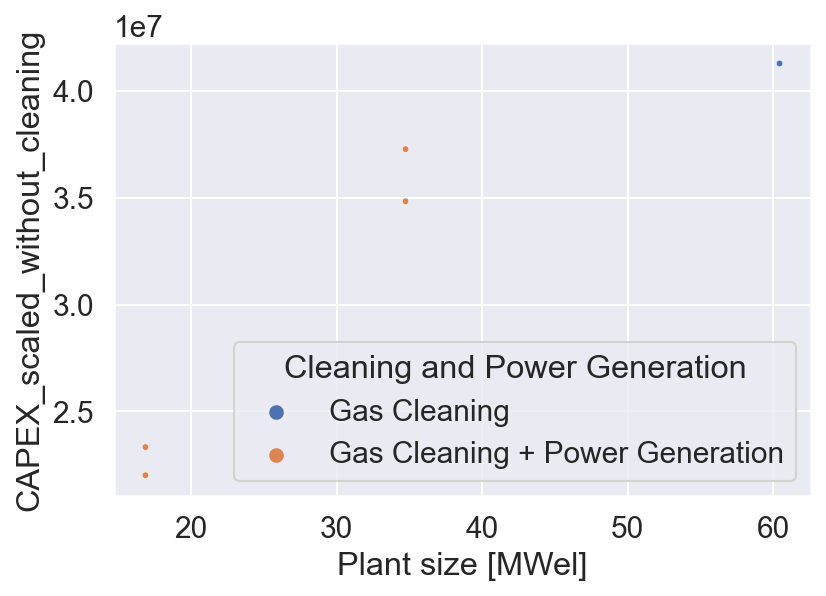

In [22]:
# Show data
fig, ax = plt.subplots(dpi=150)
sns.scatterplot(data=df_gas_fluidised[df_gas_fluidised["Plant size [MWel]"]>5], x="Plant size [MWel]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=10)
plt.show()


Straight line fit: R2: 0.855; RMSE: 2936630; MAPE: 9 %
Power curve fit: R2: 0.957; RMSE: 1594226; MAPE: 4 %
2nd degree polynomial fit: R2: 0.987; RMSE: 877257; MAPE: 3 %
3rd degree polynomial: R2: 0.987; RMSE: 877257; MAPE: 3 %


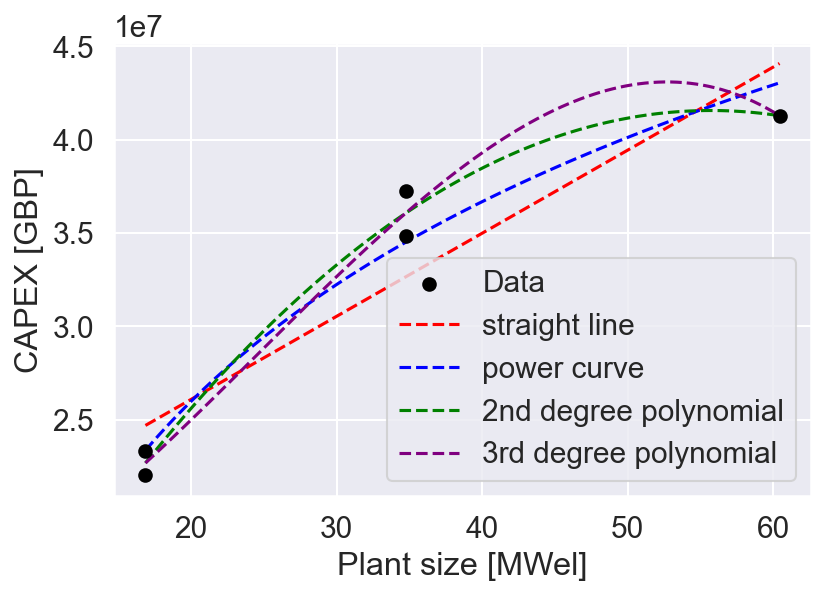

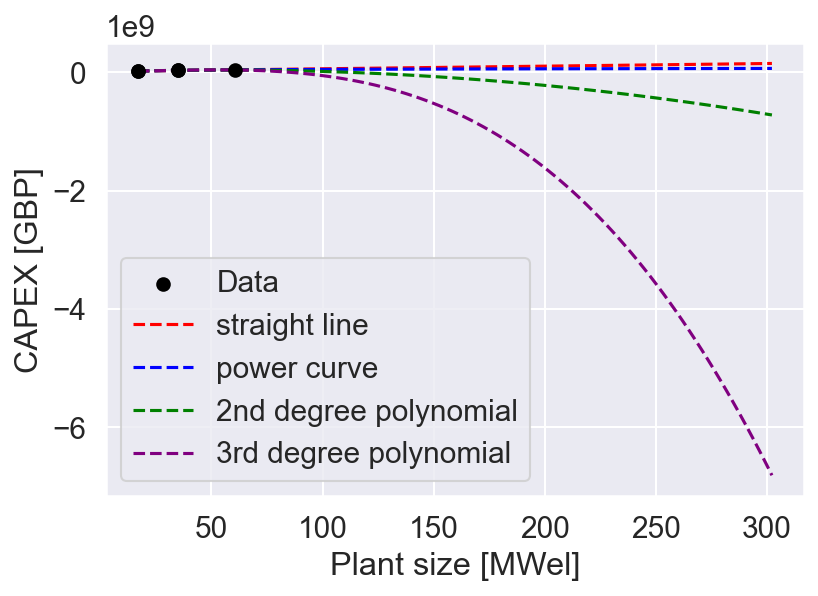

{'straight_line': {'Constants': array([  445257.95261788, 17178017.86754369]),
  'R2': 0.8547548376030754,
  'RMSE': 2936630.1622892176},
 'power_curve': {'Constants': array([ 6.86878510e+10,  2.24492174e-04, -6.87080765e+10]),
  'R2': 0.9571941887571288,
  'RMSE': 1594225.6154431275},
 '2nd_degree_polynomial': {'Constants': array([1394411.98300915,  -12513.0663272 , 2720854.81109833]),
  'R2': 0.9870384418268785,
  'RMSE': 877257.3661369452},
 '3rd_degree_polynomial': {'Constants': array([ 1.72009360e+05,  2.44641150e+04, -3.30066391e+02,  1.44001378e+07]),
  'R2': 0.9870384418268765,
  'RMSE': 877257.3661370131},
 'data_range': {'min': 16.855378950919803, 'max': 60.44089063568641}}

In [23]:
# Show curve fit
display_curve_fits(dataframe=df_gas_fluidised[df_gas_fluidised["Plant size [MWel]"]>5], x_data_label="Plant size [MWel]", y_data_label="CAPEX_scaled_without_cleaning", plot_y_label="CAPEX [GBP]")


Power curve fits data reasonably well in the shown region.

#### Compare predictions from model which has been fit to small scale-data and predictions from model which has been fit to medium-scale data.

In [24]:
pred_gas_5MW_small = func_straight_line(5, *[1307335.12547653,    9876.32017483])
pred_gas_5MW_medium = func_power_curve(5, *[ 6.86878510e+10,  2.24492174e-04, -6.87080765e+10])

print("Prediction for small-scale MWel gasification model at 5MWel:", pred_gas_5MW_small)
print("Prediction for medium-scale MWel gasification model at 5MWel:", pred_gas_5MW_medium)
print(f"Percentage difference between predictions: {100 * abs((pred_gas_5MW_medium-pred_gas_5MW_small)/pred_gas_5MW_small):.2f} %")

Prediction for small-scale MWel gasification model at 5MWel: 6546551.94755748
Prediction for medium-scale MWel gasification model at 5MWel: 4596331.392715454
Percentage difference between predictions: 29.79 %


They agree well with each other - could use small-scale data to make predictions from 0-5 MWel and medium scale data to make predictions from 5-70 MWel.

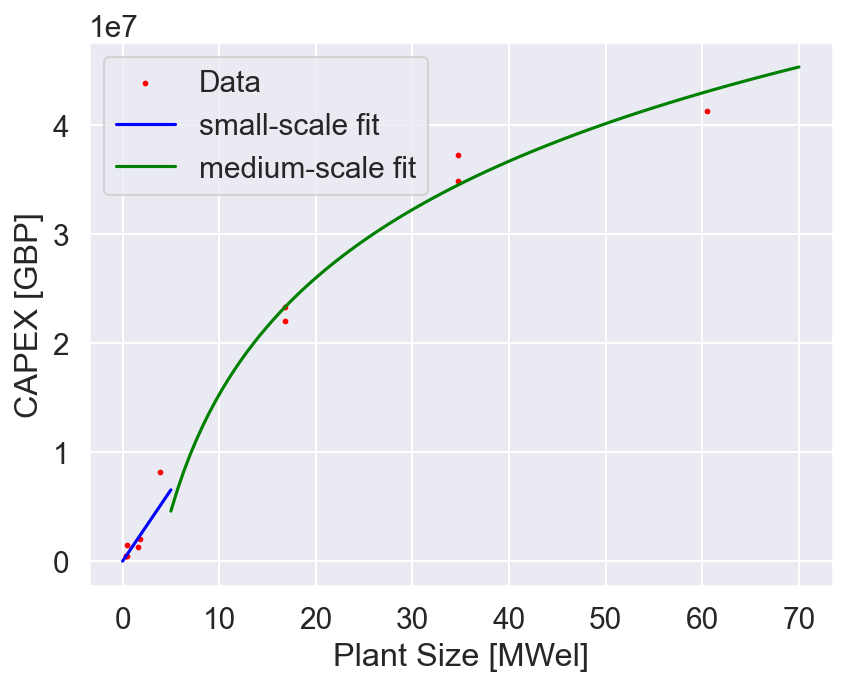

In [25]:
# Display both regression fits in same plot
x_array_gas_small_scale =np.linspace(start=0, stop=5, num=100)
x_array_gas_medium_scale = np.linspace(start=5, stop=70, num=100)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
ax.scatter(df_gas_fluidised["Plant size [MWel]"], df_gas_fluidised["CAPEX_scaled_without_cleaning"], label="Data", color="red", s=3)
ax.plot(x_array_gas_small_scale, func_straight_line(x_array_gas_small_scale, *[1307335.12547653,    9876.32017483]), label="small-scale fit", color="blue")
ax.plot(x_array_gas_medium_scale, func_power_curve(x_array_gas_medium_scale, *[ 6.86878510e+10,  2.24492174e-04, -6.87080765e+10]), label="medium-scale fit", color="green")
ax.set_xlabel("Plant Size [MWel]")
ax.set_ylabel("CAPEX [GBP]")
plt.legend()
plt.show()



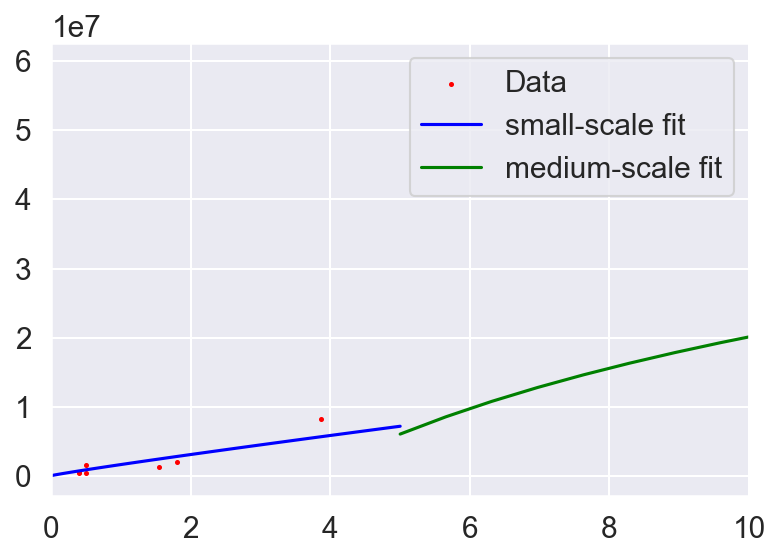

In [26]:
# Zoom in on boundary region
x_array_gas_small_scale =np.linspace(start=0, stop=5, num=100)
x_array_gas_medium_scale = np.linspace(start=5, stop=70, num=100)
fig, ax = plt.subplots(dpi=150)
ax.scatter(df_gas_fluidised["Plant size [MWel]"], df_gas_fluidised["CAPEX_scaled_without_cleaning"], label="Data", color="red", s=2)
ax.plot(x_array_gas_small_scale, func_power_curve(x_array_gas_small_scale, *[1.60758490e+06, 9.26748791e-01, 3.78109150e+04]), label="small-scale fit", color="blue")
ax.plot(x_array_gas_medium_scale, func_power_curve(x_array_gas_medium_scale, *[ 9.22715391e+10,  2.19890560e-04, -9.22981522e+10]), label="medium-scale fit", color="green")
ax.set_xlim(0,10)
plt.legend()
plt.show()

Good model.
Cost initially increases more strongly with size (i.e. in the 0-5 MWel region).
In the medium to large-scale plant region, cost increases more slowly - likely due to economies of scale.
As previously noted, the two models agree well in the boundary region - i.e. around 5 MWel.

#### Fixed bed gasifier model

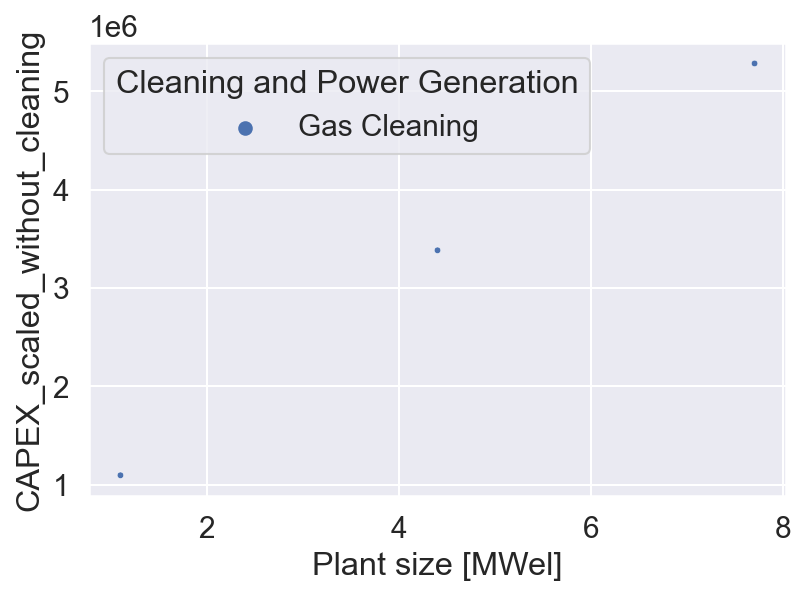

In [27]:
# Show data for fixed bed reactors only
df_gas_fixed = df_gas[df_gas["Type"] == "fixed bed"]

fig, ax = plt.subplots(dpi=150)
sns.scatterplot(data=df_gas_fixed, x="Plant size [MWel]", y="CAPEX_scaled_without_cleaning", hue="Cleaning and Power Generation", s=10)
plt.show()


Straight line fit: R2: 0.997; RMSE: 91436; MAPE: 4 %


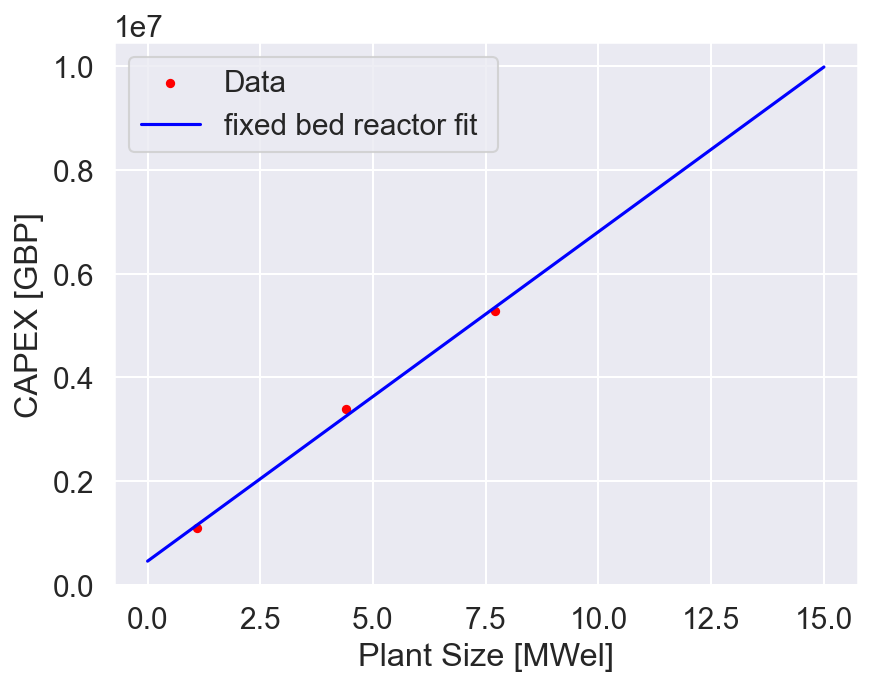

In [28]:
from functions.general import MAPE
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit

# # Show curve fit
# display_curve_fits(dataframe=df_gas_fixed, x_data_label="Plant size [MWel]", y_data_label=currency_and_CEPCI_scaled_label_gas)
x_array_gas_fixed_bed =np.linspace(start=0, stop=15, num=100)

popt_straight_line_fixed_bed, _ = curve_fit(func_straight_line, df_gas_fixed["Plant size [MWel]"], df_gas_fixed["CAPEX_scaled_without_cleaning"])
y_fit_straight_line_fixed_bed = func_straight_line(x_array_gas_fixed_bed, *popt_straight_line_fixed_bed)

r2_straight_line_fixed_bed = r2_score(df_gas_fixed["CAPEX_scaled_without_cleaning"], func_straight_line(df_gas_fixed["Plant size [MWel]"], *popt_straight_line_fixed_bed))
rmse_straight_line_fixed_bed = mean_squared_error(df_gas_fixed["CAPEX_scaled_without_cleaning"],
                                        func_straight_line(df_gas_fixed["Plant size [MWel]"], *popt_straight_line_fixed_bed),
                                        squared=False)
MAPE_straight_line_fixed_bed = MAPE(df_gas_fixed["CAPEX_scaled_without_cleaning"], func_straight_line(df_gas_fixed["Plant size [MWel]"], *popt_straight_line_fixed_bed))
print(f"Straight line fit: R2: {r2_straight_line_fixed_bed:.3f}; RMSE: {rmse_straight_line_fixed_bed:.0f}; MAPE: {MAPE_straight_line_fixed_bed:.0f} %")

fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
ax.scatter(df_gas_fixed["Plant size [MWel]"], df_gas_fixed["CAPEX_scaled_without_cleaning"], label="Data", color="red", s=12)
ax.plot(x_array_gas_fixed_bed, func_straight_line(x_array_gas_fixed_bed, *popt_straight_line_fixed_bed), label="fixed bed reactor fit ", color="blue")
ax.set_xlabel("Plant Size [MWel]")
ax.set_ylabel("CAPEX [GBP]")
plt.legend()
plt.show()



In [43]:
popt_straight_line_fixed_bed

array([634900.58127436, 460157.30152573])

Curve fit function currently does not work as 3rd degree polynomial has more parameters than data points. Hence, data was fitted manually.

Good fit achieved, but then all data points come from same reference - could still use this to model fixed-bed reactor cost.
If outside this range we would need to default to fluidised bed model - and display warning to user.
Error is very small - but realistically should be higher - consider using error of fluidised bed model etc.
Or just use small error with caveat that it is very reliant on the data from the reference.

#### CHP

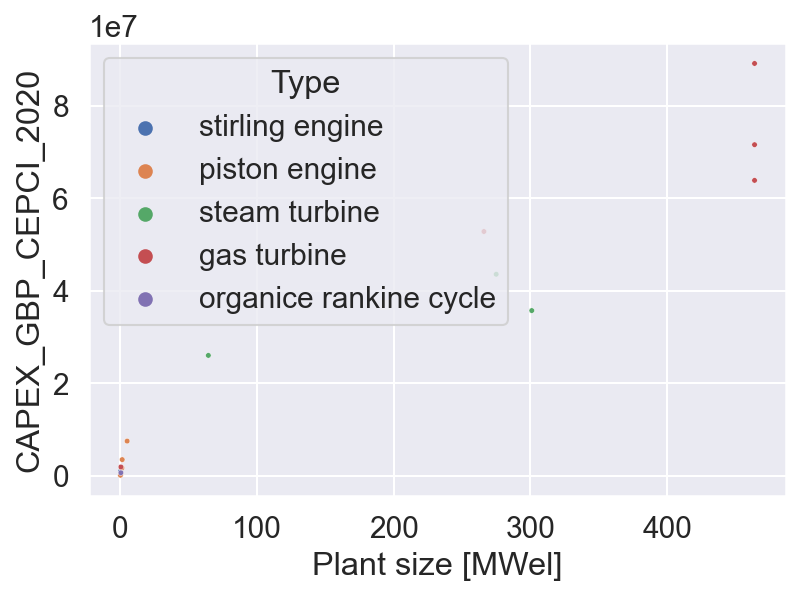

In [29]:
fig, ax = plt.subplots(dpi=150)
sns.scatterplot(data=df_CHP, x="Plant size [MWel]", y="CAPEX_GBP_CEPCI_2020", hue="Type", s=7)
plt.show()


Split data into the two previously identified clusters - cut off at 5 MWel.

#### Small-scale plants of a size <=5 MWel

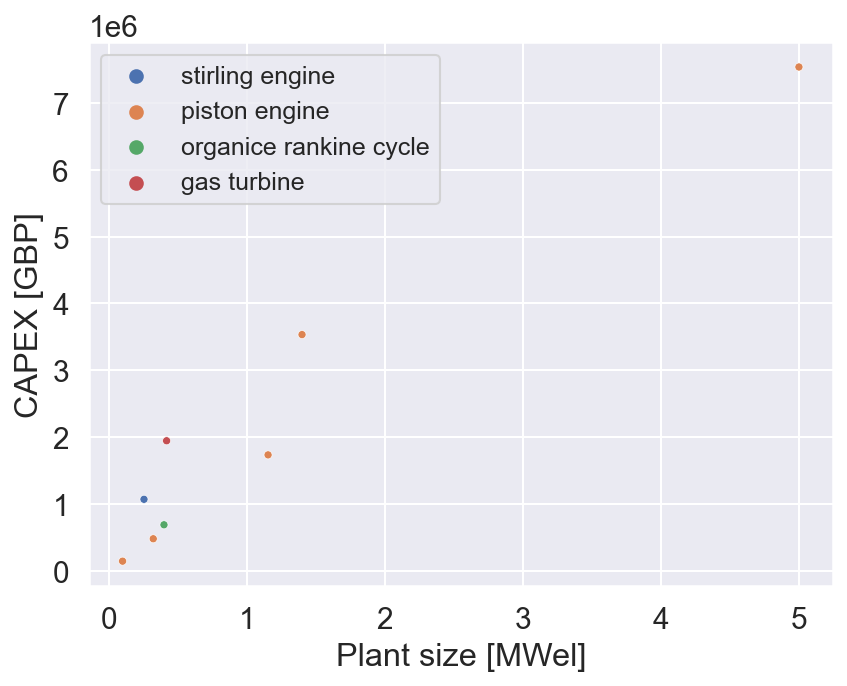

In [30]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df_CHP[df_CHP["Plant size [MWel]"]<=5], x="Plant size [MWel]", y="CAPEX_GBP_CEPCI_2020", hue="Type", s=15)
ax.set_ylabel("CAPEX [GBP]")
plt.legend(loc='upper left', fontsize=12)
plt.show()


Straight line fit: R2: 0.936; RMSE: 572451; MAPE: 77 %
Power curve fit: R2: 0.948; RMSE: 515339; MAPE: 46 %
2nd degree polynomial fit: R2: 0.948; RMSE: 517543; MAPE: 54 %
3rd degree polynomial: R2: 0.948; RMSE: 516147; MAPE: 58 %


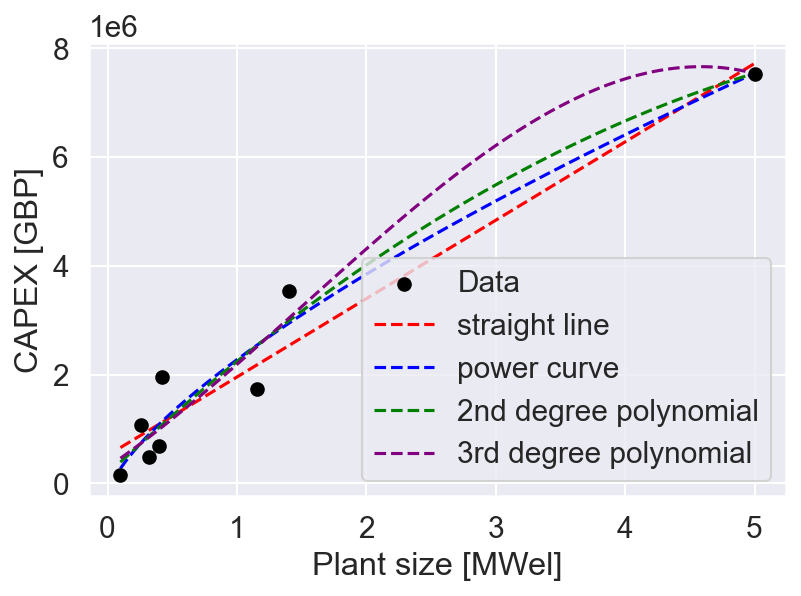

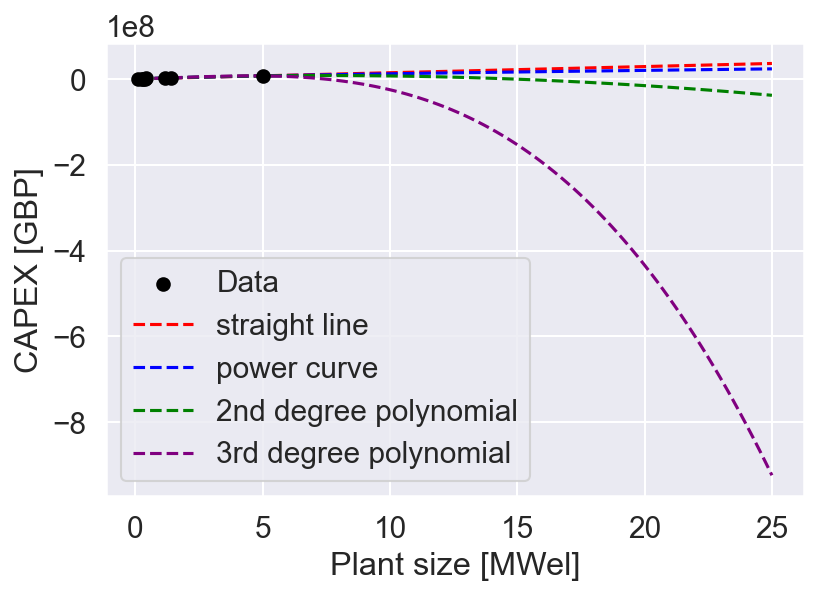

{'straight_line': {'Constants': array([1440654.08420797,  515015.44262064]),
  'R2': 0.9363044868981978,
  'RMSE': 572451.4323211064},
 'power_curve': {'Constants': array([ 2.48558907e+06,  7.06585347e-01, -2.11467298e+05]),
  'R2': 0.9483801428426042,
  'RMSE': 515338.5430989351},
 '2nd_degree_polynomial': {'Constants': array([2220005.35359647, -149365.65443881,  171166.60130856]),
  'R2': 0.9479375680345672,
  'RMSE': 517543.0152589958},
 '3rd_degree_polynomial': {'Constants': array([1624752.0663634 ,  341543.02963576,  -75394.44359349,
          297077.54104102]),
  'R2': 0.9482181193564211,
  'RMSE': 516146.6771664686},
 'data_range': {'min': 0.1, 'max': 5.0}}

In [31]:
# Show curve fit
display_curve_fits(dataframe=df_CHP[df_CHP["Plant size [MWel]"]<=5], x_data_label="Plant size [MWel]", y_data_label=currency_and_CEPCI_scaled_label_CHP, plot_y_label="CAPEX [GBP]")

- Good fit achieved by power curve.
- Polynomial fits become unstable outside region.


#### Medium-scale plants of a size >5 MWel

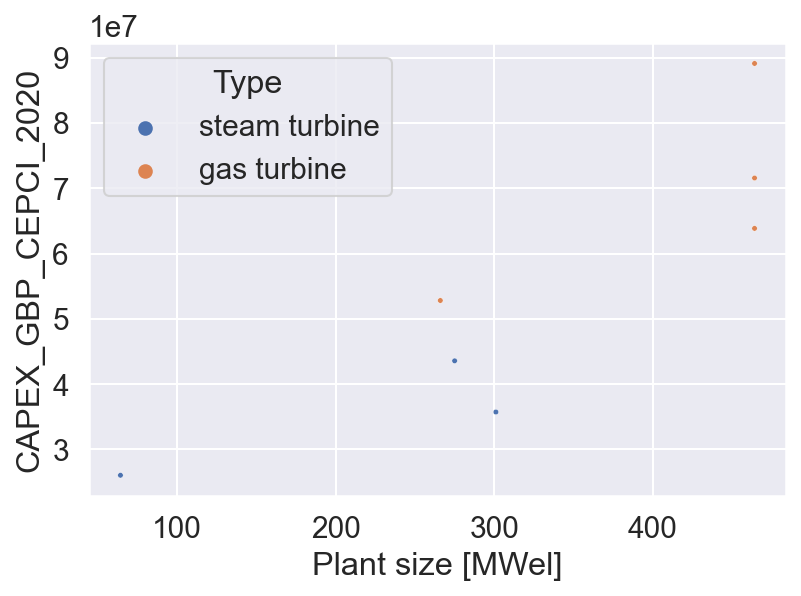

In [32]:
fig, ax = plt.subplots(dpi=150)
sns.scatterplot(data=df_CHP[df_CHP["Plant size [MWel]"]>5], x="Plant size [MWel]", y="CAPEX_GBP_CEPCI_2020", hue="Type", s=7)
plt.show()


Straight line fit: R2: 0.763; RMSE: 9852006; MAPE: 17 %
Power curve fit: R2: 0.801; RMSE: 9012877; MAPE: 13 %
2nd degree polynomial fit: R2: 0.801; RMSE: 9010807; MAPE: 13 %
3rd degree polynomial: R2: 0.878; RMSE: 7057561; MAPE: 7 %


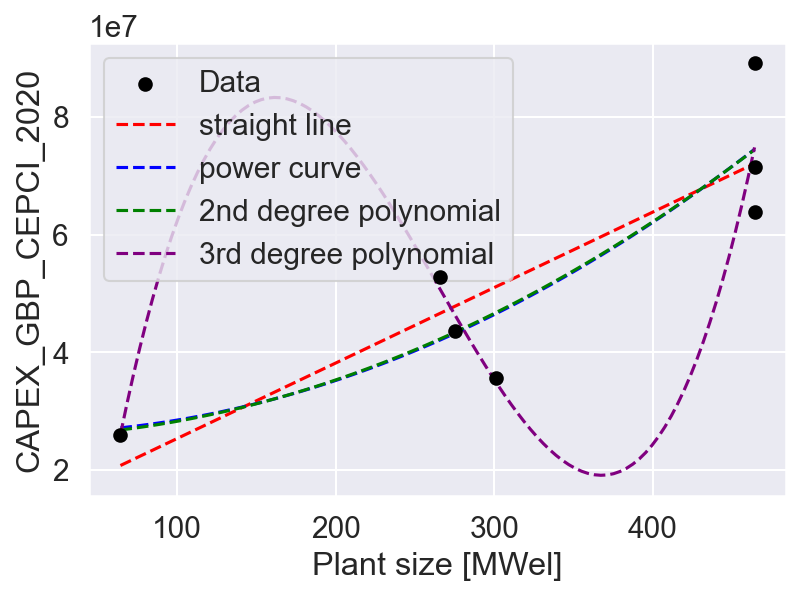

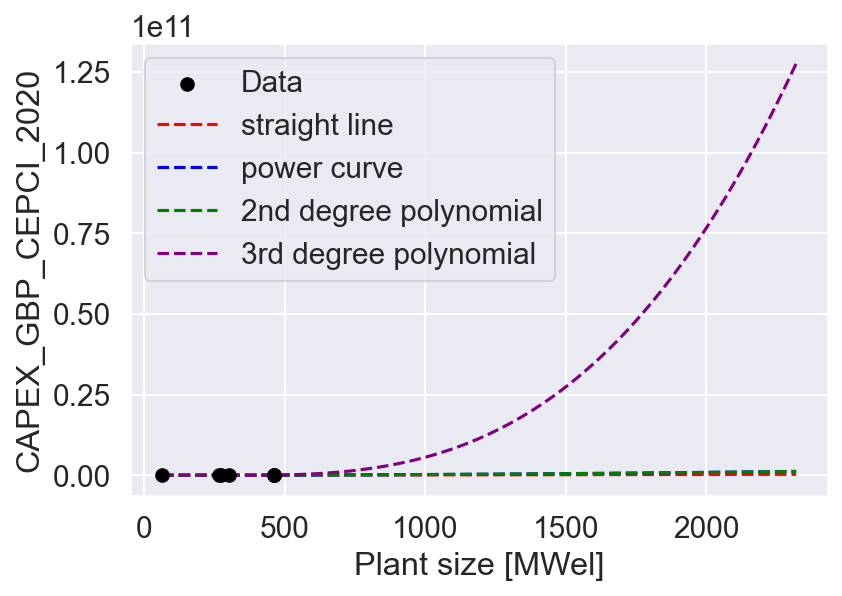

{'straight_line': {'Constants': array([  128387.29450366, 12515990.47723896]),
  'R2': 0.7625162365498113,
  'RMSE': 9852006.319256717},
 'power_curve': {'Constants': array([2.25659357e+02, 1.99896182e+00, 2.62538618e+07]),
  'R2': 0.8012480478489085,
  'RMSE': 9012876.536794815},
 '2nd_degree_polynomial': {'Constants': array([6.09438779e+03, 2.14089477e+02, 2.55414158e+07]),
  'R2': 0.8013393157171961,
  'RMSE': 9010806.920684587},
 '3rd_degree_polynomial': {'Constants': array([ 2.64508332e+06, -1.17590815e+04,  1.48022517e+01, -9.94917439e+07]),
  'R2': 0.8781308208845908,
  'RMSE': 7057561.3702334035},
 'data_range': {'min': 64.411, 'max': 464.0}}

In [33]:
# Show curve fit
display_curve_fits(dataframe=df_CHP[df_CHP["Plant size [MWel]"]>5], x_data_label="Plant size [MWel]", y_data_label=currency_and_CEPCI_scaled_label_CHP)

- No great fit achieved
- Power curve would indicate price proportionally goes up instead of down over this region.
    - Which is contrary to what economies of scale would indicate.
- Use linear fit here instead even if it isn't the best fit.
- Overall region of high uncertainty which will be reflected in the model.

#### Compare predictions from model which has been fit to small scale data and predictions from model which has been fit to medium-scale data.

In [34]:
pred_CHP_5MW_small = func_power_curve(5, *[2.48558907e+06, 7.06585347e-01, -2.11467298e+05])
pred_CHP_5MW_medium = func_straight_line(5, *[128387.29450366, 12515990.47723896])

print("Prediction for small-scale CHP model at 5MWel:", pred_CHP_5MW_small)
print("Prediction for medium-scale CHP model at 5MWel:", pred_CHP_5MW_medium)
print(f"Percentage difference between predictions: {100 * abs((pred_CHP_5MW_medium - pred_CHP_5MW_small) / pred_CHP_5MW_small):.2f} %")

Prediction for small-scale CHP model at 5MWel: 7538703.856636505
Prediction for medium-scale CHP model at 5MWel: 13157926.949757261
Percentage difference between predictions: 74.54 %


Large difference - basically uncertainty in medium-scale model is too large to get a good prediction.

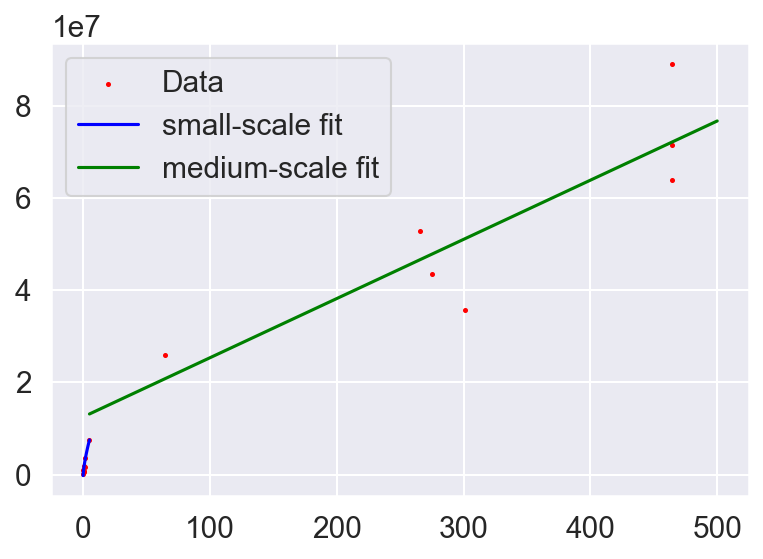

In [35]:
# Display both regression fits in same plot
x_array_CHP_small_scale =np.linspace(start=0, stop=5, num=100)
x_array_CHP_medium_scale = np.linspace(start=5, stop=500, num=100)
fig, ax = plt.subplots(dpi=150)
ax.scatter(df_CHP["Plant size [MWel]"], df_CHP[currency_and_CEPCI_scaled_label_CHP], label="Data", color="red", s=2)
ax.plot(x_array_CHP_small_scale, func_power_curve(x_array_CHP_small_scale, *[2.48558907e+06, 7.06585347e-01, -2.11467298e+05]), label="small-scale fit", color="blue")
ax.plot(x_array_CHP_medium_scale, func_straight_line(x_array_CHP_medium_scale, *[128387.29450366, 12515990.47723896]), label="medium-scale fit", color="green")
plt.legend()
plt.show()

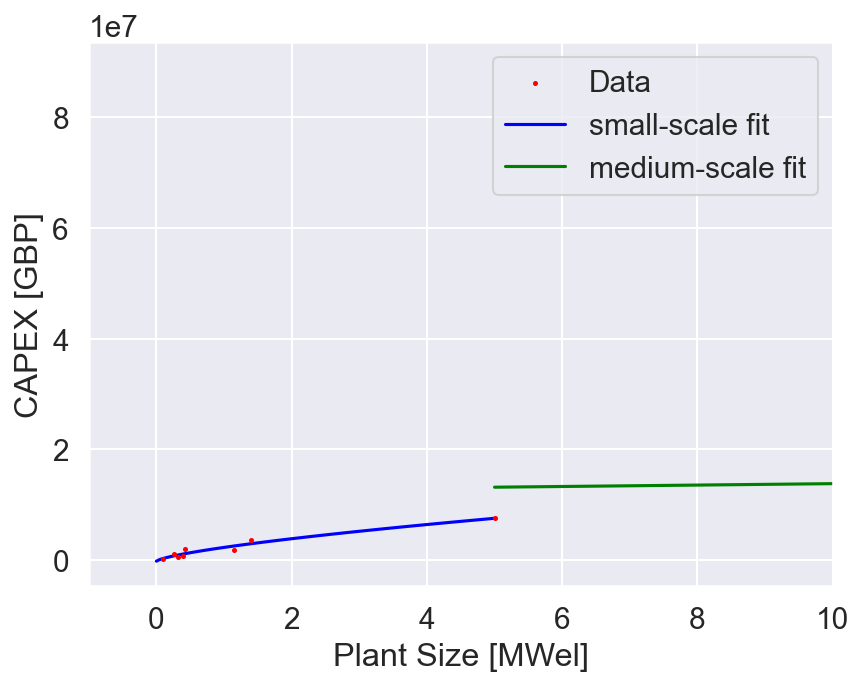

In [36]:
# Repeat plot but now zoom in on 5 MWel region
x_array_CHP_small_scale =np.linspace(start=0, stop=5, num=100)
x_array_CHP_medium_scale = np.linspace(start=5, stop=500, num=100)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
ax.scatter(df_CHP["Plant size [MWel]"], df_CHP[currency_and_CEPCI_scaled_label_CHP], label="Data", color="red", s=2, zorder=10)
ax.plot(x_array_CHP_small_scale, func_power_curve(x_array_CHP_small_scale, *[2.48558907e+06, 7.06585347e-01, -2.11467298e+05]), label="small-scale fit", color="blue")
ax.plot(x_array_CHP_medium_scale, func_straight_line(x_array_CHP_medium_scale, *[128387.29450366, 12515990.47723896]), label="medium-scale fit", color="green")
ax.set_xlabel("Plant Size [MWel]")
ax.set_ylabel("CAPEX [GBP]")
ax.set_xlim(-1, 10)
plt.legend()
plt.show()


General trend makes sense.
Cost initially increases more strongly with size (i.e. in the 0-5 MWel region).
In the medium to large-scale plant region, cost increases more slowly - likely due to economies of scale.
As previously noted, the two models don't agree very well in the boundary region - i.e. around 5 MWel.

### Compare component costs of CHP and gasification

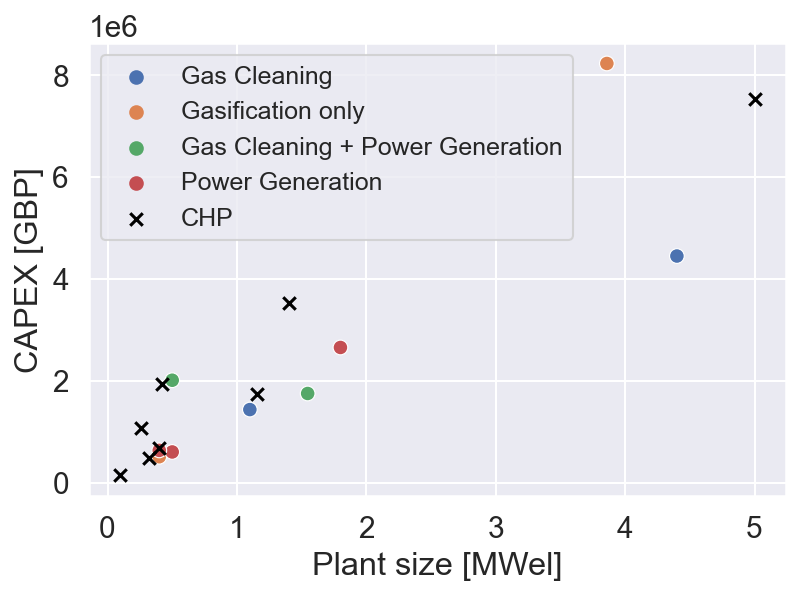

In [37]:
fig, ax = plt.subplots(dpi=150)
sns.scatterplot(data=df_gas[df_gas["Plant size [MWel]"]<=5], x="Plant size [MWel]", y="CAPEX_GBP_CEPCI_2020", hue="Cleaning and Power Generation", s=50)
ax.scatter(df_CHP[df_CHP["Plant size [MWel]"]<=5]["Plant size [MWel]"], df_CHP[df_CHP["Plant size [MWel]"]<=5]["CAPEX_GBP_CEPCI_2020"], label="CHP", color="black", marker="x")
plt.legend(fontsize=12)
ax.set_ylabel("CAPEX [GBP]")
plt.show()


Difficult to interpret these results
- In general, power generation and syngas cleaning typically led to an increase in gasification CAPEX.
    - However, the data was not clear enough to identify any trends.
    - Ultimately some resources quoted that the gasifier only costs a fraction of the power generation system
        - https://doi.org/10.1016/j.compchemeng.2020.106758
        - In reality, there are likely significant differences from system to system.
    - 3 references quoted that gas cleaning cost 17, 24, and 33 % of the overall gasification scheme
        - References:
            - https://doi.org/10.1002/er.3038
            - https://doi.org/10.1002/bbb.137
            - "Process Design and Economics for Conversion of Lignocellulosic Biomass to Ethanol: Thermochemical Pathway by Indirect Gasification and Mixed Alcohol Synthesis"
        - None of these references include power generation systems.

#### Gas cleaning cost

How would I account for gas cleaning as part of gasification cost?
- Decrease the cost of all data points which have 1. gas cleaning or 2. gas cleaning + power generation or 3. power generation included.
    - This would add no extra cost for power generation - as at this stage this cannot be accounted for effectively and no clear trend exists, that would indicate that data points including gas generation are more expensive than other data points.
    -    This also assumes that whenever power generation was included in the cost, gas cleaning was also included even if not directly mentioned in the reference.
- Based on these assumptions the following approach can be taken.
    - Decrease all cost data for these data points by the mode cost of gas cleaning based on the above quoted literature - i.e. 24%
    - Then we can model the gas cleaning cost separately but dependent on gasification cost.
    - Use the following approach:
        - Gas cleaning cost = (Gasification cost / 0.76) * triangular_distribution_draw(lower=0.17, mode=0.24, upper=0.33)
        - This way the original cost and not the scaled cost is used as reference of which a percentage is assumed.
        - If the scaled cost was used the model would underestimate.